##### Import libraries for data handling, similarity computation, model building, and evaluation metrics

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score,precision_recall_curve
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Loading datasets:
# - drug_interaction: drug-drug interaction data across cell lines
# - drug_feature: features representing each unique drug (indexed by drug name)
# - cell_feature: features representing each cell line (indexed by cell line name)

In [3]:
drug_interaction=pd.read_csv("drug_interaction_drugcomb.csv",low_memory=False)
drug_feature=pd.read_csv("drug_feature.csv",index_col=0)
cell_feature=pd.read_csv("final_cell_line_feature.csv",index_col=0)

In [4]:
drug_interaction.shape    # 1,048,575 drug-drug interactions recorded across various cell lines.

(1048575, 18)

In [5]:
drug_interaction.head()

,block_id,drug_row,drug_col,cell_line_name,conc_r_unit,conc_c_unit,css,synergy_zip,synergy_bliss,synergy_loewe,synergy_hsa,ic50_row,ic50_col,ri_row,ri_col,css_row,css_col,S
0,1,5-FU,ABT-888,A2058,uM,uM,30.869,3.865915,6.256584,-2.951386,5.536903,5.126836,3.267734,11.471,-0.441,22.545,39.193,19.839
1,2,5-FU,ABT-888,A2058,uM,uM,27.460,8.247403,12.333896,3.125927,11.614215,5.126836,3.267734,11.471,-0.441,24.135,30.785,16.430
2,3,5-FU,ABT-888,A2058,uM,uM,29.901,6.063440,11.660209,2.452239,10.940528,5.126836,3.267734,11.471,-0.441,25.561,34.241,18.871
3,4,5-FU,ABT-888,A2058,uM,uM,24.016,-4.280231,5.145209,-4.062761,4.425528,5.126836,3.267734,11.471,-0.441,16.661,31.371,12.986
4,5,5-FU,AZD1775,A2058,uM,uM,66.847,12.284698,15.765467,10.409407,18.656340,5.126836,0.266027,11.471,25.164,76.501,57.193,30.212


##### Creating the target label 'synergistic_status' based on 'synergy_zip':
##### If 'synergy_zip' value is greater than 0, label as 1 (synergistic), else 0 (non-synergistic).

In [6]:
drug_interaction['synergistic_status'] = drug_interaction['synergy_zip'].apply(lambda x: 1 if x > 0 else 0)

##### Selecting only essential columns for prediction:
##### 'drug_row', 'drug_col', and 'cell_line_name' define the drug pair and context,
##### while 'synergistic_status' is the target label for synergy prediction.

In [7]:
drug_interaction=drug_interaction[['drug_row','drug_col','cell_line_name','synergistic_status']]

In [8]:
drug_interaction.head()

,drug_row,drug_col,cell_line_name,synergistic_status
0,5-FU,ABT-888,A2058,1
1,5-FU,ABT-888,A2058,1
2,5-FU,ABT-888,A2058,1
3,5-FU,ABT-888,A2058,0
4,5-FU,AZD1775,A2058,1


In [9]:
drug_interaction.isnull().sum()

drug_row                   0
drug_col              582542
cell_line_name             0
synergistic_status         0
dtype: int64

##### 'drug_col' is essential for defining a drug pair interaction.
##### Rows with missing 'drug_col' cannot represent valid interactions and must be dropped.

In [10]:
drug_interaction.dropna(inplace=True)

In [11]:
drug_interaction.isnull().sum()

drug_row              0
drug_col              0
cell_line_name        0
synergistic_status    0
dtype: int64

In [12]:
drug_interaction.shape #After preprocessing, 1,048,575 drug-drug interactions across various cell lines remain.

(466033, 4)

In [13]:
drug_interaction.synergistic_status.value_counts()    

synergistic_status
0    258510
1    207523
Name: count, dtype: int64

##### The dataset has 258,510 non-synergistic (label 0) and 207,523 synergistic (label 1) samples.
##### This shows a slight class imbalance (~55% vs ~45%), which should be handled during training.

In [14]:
interaction_drug= set(drug_interaction['drug_row']).union(set(drug_interaction['drug_col']))

In [15]:
print(f"total number of drug participating in interaction is {len(interaction_drug)}")

total number of drug participating in interaction is 4150


In [16]:
drug_feature.head()

,drug,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5-FU,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABT-888,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AZD1775,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BEZ-235,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BORTEZOMIB,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### The dataset includes drug features for 4,051 unique drugs to represent each drug in the interaction pairs 

In [17]:
drug_feature.shape

(4051, 2049)

In [18]:
all_drug_with_feature=set(drug_feature['drug'].unique())

In [19]:
print(f"There are a total of {len(all_drug_with_feature)} features available for different drugs ")

There are a total of 4051 features available for different drugs 


##### Confirming missing feature of drug in drug interaction dataset

In [20]:
if interaction_drug.issubset(all_drug_with_feature):
    print("All interaction drugs are present in the feature set.")
else:
    print(" Some interaction drugs are missing in the feature set.")
    missing = interaction_drug - all_drug_with_feature
    
print(f"drug without available feature in drug interaciton {len(missing)}")

 Some interaction drugs are missing in the feature set.
drug without available feature in drug interaciton 99


##### Removing interactions for drug_interaction involving drugs not in the 4,051-drug feature set to ensure all interactions have corresponding features.

In [21]:
drug_interaction = drug_interaction[
    ~drug_interaction['drug_row'].isin(missing) &
    ~drug_interaction['drug_col'].isin(missing)
].reset_index(drop=True)

In [22]:
interaction_drug= set(drug_interaction['drug_row']).union(set(drug_interaction['drug_col']))
all_drug_with_feature=set(drug_feature['drug'].unique())
if interaction_drug.issubset(all_drug_with_feature):
    print("All interaction drugs are present in the feature set.")
else:
    print(" Some interaction drugs are missing in the feature set.")
    
missing = interaction_drug - all_drug_with_feature
    
print(f"drug without available feature in drug interaciton {len(missing)}")

All interaction drugs are present in the feature set.
drug without available feature in drug interaciton 0


##### Assingning unique id to each drug

In [23]:
drug_feature['drug_id'] = range(len(drug_feature))

In [24]:
drug_feature.head()

,drug,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,drug_id
0,5-FU,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABT-888,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,AZD1775,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,BEZ-235,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,BORTEZOMIB,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


##### Storing drug names and their corresponding IDs in drug_to_id to replace drug names with numeric IDs in the interaction dataset.

In [25]:
drug_to_id = dict(zip(drug_feature['drug'], drug_feature['drug_id']))

In [26]:
drug_to_id

{'5-FU': 0,
 'ABT-888': 1,
 'AZD1775': 2,
 'BEZ-235': 3,
 'BORTEZOMIB': 4,
 'DASATINIB': 5,
 'DINACICLIB': 6,
 'ERLOTINIB': 7,
 'GELDANAMYCIN': 8,
 'L778123': 9,
 'LAPATINIB': 10,
 'MK-2206': 11,
 'MK-4827': 12,
 'MK-5108': 13,
 'MK-8669': 14,
 'MK-8776': 15,
 'PD325901': 16,
 'SORAFENIB': 17,
 'SUNITINIB': 18,
 'TEMOZOLOMIDE': 19,
 'ZOLINZA': 20,
 'OXALIPLATIN': 21,
 'SN-38': 22,
 'TOPOTECAN': 23,
 'CARBOPLATIN': 24,
 'CYCLOPHOSPHAMIDE': 25,
 'DEXAMETHASONE': 26,
 'DOXORUBICIN': 27,
 'ETOPOSIDE': 28,
 'GEMCITABINE': 29,
 'VINORELBINE': 30,
 'METFORMIN': 31,
 'METHOTREXATE': 32,
 'MITOMYCINE': 33,
 'MK-4541': 34,
 'MRK-003': 35,
 'PACLITAXEL': 36,
 'VINBLASTINE': 37,
 'RAMELTEON': 38,
 'BRETYLIUM TOSYLATE': 39,
 '3-AMINO-2-OXAZOLIDINONE': 40,
 'METYROSINE': 41,
 'GABAPENTIN': 42,
 'RUFINAMIDE': 43,
 'FEBUXOSTAT': 44,
 'DUTASTERIDE': 45,
 'PRAMIPEXOLE': 46,
 'VALPROIC ACID': 47,
 'TIZOXANIDE': 48,
 'TESTOLACTONE': 49,
 'ACAMPROSATE': 50,
 'DESOXYCORTICOSTERONE PIVALATE': 51,
 'ALTRETAMI

##### Dropping 'drug_id' and 'drug' columns as the index now represents the drug ID,

In [27]:
drug_feature.drop(columns=['drug_id','drug'],inplace=True)

In [28]:
drug_interaction['drug_row_id'] = drug_interaction['drug_row'].map(drug_to_id)
drug_interaction['drug_col_id'] = drug_interaction['drug_col'].map(drug_to_id)

##### Replacing drug names with their corresponding unique IDs in the drug interaction dataset using the drug_to_id mapping.

In [29]:
drug_interaction.head()

,drug_row,drug_col,cell_line_name,synergistic_status,drug_row_id,drug_col_id
0,5-FU,ABT-888,A2058,1,0,1
1,5-FU,ABT-888,A2058,1,0,1
2,5-FU,ABT-888,A2058,1,0,1
3,5-FU,ABT-888,A2058,0,0,1
4,5-FU,AZD1775,A2058,1,0,2


In [30]:
drug_interaction = drug_interaction.drop(columns=['drug_row', 'drug_col'])
cols = ['drug_row_id', 'drug_col_id'] + [col for col in drug_interaction.columns if col not in ['drug_row_id', 'drug_col_id']]
drug_interaction = drug_interaction[cols]

In [31]:
drug_interaction.head()

,drug_row_id,drug_col_id,cell_line_name,synergistic_status
0,0,1,A2058,1
1,0,1,A2058,1
2,0,1,A2058,1
3,0,1,A2058,0
4,0,2,A2058,1


##### Drug similarity based on feature

In [32]:
cos_sim_matrix = cosine_similarity(drug_feature)

In [33]:
cos_sim_matrix

array([[1.        , 0.17699808, 0.11211037, ..., 0.11646819, 0.09727208,
        0.14808722],
       [0.17699808, 1.        , 0.2073627 , ..., 0.28200837, 0.22898571,
        0.21912525],
       [0.11211037, 0.2073627 , 1.        , ..., 0.17366199, 0.20719896,
        0.34698416],
       ...,
       [0.11646819, 0.28200837, 0.17366199, ..., 1.        , 0.21525296,
        0.27526932],
       [0.09727208, 0.22898571, 0.20719896, ..., 0.21525296, 1.        ,
        0.26000576],
       [0.14808722, 0.21912525, 0.34698416, ..., 0.27526932, 0.26000576,
        1.        ]], shape=(4051, 4051))

In [34]:
cos_sim_matrix.shape

(4051, 4051)

In [35]:
drug_feature

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4047,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4048,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4049,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
drug_feature=np.array(drug_feature)
X = torch.tensor(drug_feature, dtype=torch.float32)        
A_label = torch.tensor(cos_sim_matrix, dtype=torch.float32)

In [37]:
A_label

tensor([[1.0000, 0.1770, 0.1121,  ..., 0.1165, 0.0973, 0.1481],
        [0.1770, 1.0000, 0.2074,  ..., 0.2820, 0.2290, 0.2191],
        [0.1121, 0.2074, 1.0000,  ..., 0.1737, 0.2072, 0.3470],
        ...,
        [0.1165, 0.2820, 0.1737,  ..., 1.0000, 0.2153, 0.2753],
        [0.0973, 0.2290, 0.2072,  ..., 0.2153, 1.0000, 0.2600],
        [0.1481, 0.2191, 0.3470,  ..., 0.2753, 0.2600, 1.0000]])

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = X.to(device)
A_label = A_label.to(device)

In [39]:
def normalize_adj_torch(A):
    I = torch.eye(A.size(0)).to(A.device)
    A_hat = A + I
    D_hat = torch.diag(torch.pow(A_hat.sum(1), -0.5))
    return D_hat @ A_hat @ D_hat

norm_adj = normalize_adj_torch(A_label)
# norm_adj=A_label

In [40]:
class DeepGAE(nn.Module):
    def __init__(self, in_dim, h1, h2, h3, dropout=0.3):
        super(DeepGAE, self).__init__()
        self.W1 = nn.Parameter(torch.empty(in_dim, h1))
        self.W2 = nn.Parameter(torch.empty(h1, h2))
        self.W3 = nn.Parameter(torch.empty(h2, h3))
        self.decoder_weight = nn.Parameter(torch.empty(h3, h3))

        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)
        nn.init.xavier_uniform_(self.W3)
        nn.init.xavier_uniform_(self.decoder_weight)

        self.dropout = nn.Dropout(dropout)

    def encode(self, X, norm_adj):
        h1 = F.leaky_relu(norm_adj @ X @ self.W1, negative_slope=0.01)
        h1 = self.dropout(h1)
        h2 = F.leaky_relu(norm_adj @ h1 @ self.W2, negative_slope=0.01)
        h2 = self.dropout(h2)
        h3 = F.leaky_relu(norm_adj @ h2 @ self.W3, negative_slope=0.01)
        return h3

    def decode(self, Z):
        A_recon = Z @ self.decoder_weight @ Z.T
        return torch.sigmoid(A_recon)  # Keep values in [0, 1]

    def forward(self, X, norm_adj):
        Z = self.encode(X, norm_adj)
        A_pred = self.decode(Z)
        return A_pred, Z

# Create upper triangle edges
A_label_np = A_label.cpu().numpy()
n = A_label_np.shape[0]
rows, cols = np.triu_indices(n, k=1)
values = A_label_np[rows, cols]
edges = np.stack([rows, cols], axis=1)
edge_values = values

train_edges, test_edges, train_weights, test_weights = train_test_split(
    edges, edge_values, test_size=0.2, random_state=42
)
train_pos = torch.tensor(train_edges.T, dtype=torch.long).to(device)
test_pos = torch.tensor(test_edges.T, dtype=torch.long).to(device)
train_weights = torch.tensor(train_weights, dtype=torch.float32).to(device)
test_weights = torch.tensor(test_weights, dtype=torch.float32).to(device)


In [41]:
model = DeepGAE(in_dim=2048, h1=1024, h2=256, h3=128, dropout=0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [42]:
def get_loss_and_metrics(model, X, norm_adj, pos_edge_idx, true_weights):
    model.eval()
    with torch.no_grad():
        A_pred, _ = model(X, norm_adj)
        preds = A_pred[pos_edge_idx[0], pos_edge_idx[1]]
        loss = loss_fn(preds, true_weights)

        y_true = true_weights.cpu().numpy()
        y_score = preds.cpu().numpy()
        mse = mean_squared_error(y_true, y_score)
        mae = mean_absolute_error(y_true, y_score)
        r2 = r2_score(y_true, y_score)

    return loss.item(), mse, mae, r2

In [43]:
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    A_pred, _ = model(X, norm_adj)
    preds = A_pred[train_pos[0], train_pos[1]]
    loss = loss_fn(preds, train_weights)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    train_loss = loss.item()
    test_loss, mse, mae, r2 = get_loss_and_metrics(model, X, norm_adj, test_pos, test_weights)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | MSE: {mse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

# Final metrics
print("\nFinal Test Metrics:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")


Epoch 001 | Train Loss: 0.1022 | Test Loss: 0.0829 | MSE: 0.0829 | MAE: 0.2799 | R2: -17.2975
Epoch 002 | Train Loss: 0.0826 | Test Loss: 0.0107 | MSE: 0.0107 | MAE: 0.0813 | R2: -1.3497
Epoch 003 | Train Loss: 0.0107 | Test Loss: 0.0273 | MSE: 0.0273 | MAE: 0.1483 | R2: -5.0153
Epoch 004 | Train Loss: 0.0272 | Test Loss: 0.0344 | MSE: 0.0344 | MAE: 0.1714 | R2: -6.5829
Epoch 005 | Train Loss: 0.0344 | Test Loss: 0.0357 | MSE: 0.0357 | MAE: 0.1756 | R2: -6.8845
Epoch 006 | Train Loss: 0.0357 | Test Loss: 0.0351 | MSE: 0.0351 | MAE: 0.1737 | R2: -6.7507
Epoch 007 | Train Loss: 0.0351 | Test Loss: 0.0324 | MSE: 0.0324 | MAE: 0.1650 | R2: -6.1411
Epoch 008 | Train Loss: 0.0324 | Test Loss: 0.0223 | MSE: 0.0223 | MAE: 0.1307 | R2: -3.9227
Epoch 009 | Train Loss: 0.0221 | Test Loss: 0.0079 | MSE: 0.0079 | MAE: 0.0676 | R2: -0.7384
Epoch 010 | Train Loss: 0.0078 | Test Loss: 0.0325 | MSE: 0.0325 | MAE: 0.1644 | R2: -6.1729
Epoch 011 | Train Loss: 0.0327 | Test Loss: 0.0078 | MSE: 0.0078 | MA

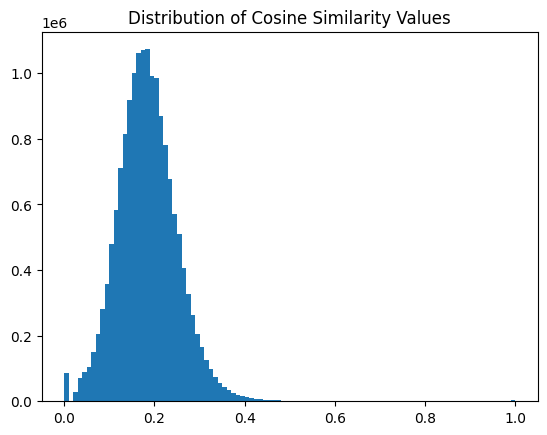

In [44]:
import matplotlib.pyplot as plt
plt.hist(A_label.cpu().numpy().flatten(), bins=100)
plt.title("Distribution of Cosine Similarity Values")
plt.show()


In [45]:
# After training
model.eval()
with torch.no_grad():
    A_pred_final, Z_final = model(X, norm_adj)  # [4051×4051], [4051×128]
    A_pred_np = A_pred_final.cpu().numpy()      # Final decoded matrix
    Z_np = Z_final.cpu().numpy() 

In [48]:
cosine_label=Z_np

In [49]:
encoded_np = np.load("cell_feature.npy")  # if on GPU, else just .numpy()

cell_names = cell_feature.iloc[:, 0].reset_index(drop=True)

# Create new DataFrame
encoded_df = pd.DataFrame(encoded_np, columns=[f'encoded_feat_{i}' for i in range(encoded_np.shape[1])])

# Combine cell names with encoded features
final_df = pd.concat([cell_names, encoded_df], axis=1)

In [50]:
final_df.shape

(717, 129)

In [51]:
import numpy as np
import pandas as pd



cell_feat_map = final_df.set_index(final_df.columns[0]) 


combined_features = []
labels = []
skipped_rows = 0

for idx, row in drug_interaction.iterrows():
    drug_row_idx = row['drug_row_id']
    drug_col_idx = row['drug_col_id']
    cell_name = row['cell_line_name']
    label = row['synergistic_status']

    if cell_name not in cell_feat_map.index:
        skipped_rows += 1
        continue  

  
    try:
        drug_row_feat = cosine_label[drug_row_idx]
        drug_col_feat = cosine_label[drug_col_idx]
    except IndexError:
        skipped_rows += 1
        continue  # skip if drug id is out of bounds

    # Extract cell features
    cell_feat = cell_feat_map.loc[cell_name].values  # shape (128,)

    # Combine all
    combined = np.concatenate([drug_row_feat, drug_col_feat, cell_feat])  # (384,)
    combined_features.append(combined)
    labels.append(label)

# Convert to final DataFrame
combined_features = np.array(combined_features)
labels = np.array(labels)

feature_cols = [f'drug_row_feat_{i}' for i in range(128)] + \
               [f'drug_col_feat_{i}' for i in range(128)] + \
               [f'cell_feat_{i}' for i in range(128)]

final_dataset = pd.DataFrame(combined_features, columns=feature_cols)
final_dataset['synergistic_status'] = labels

print(f"Final dataset shape: {final_dataset.shape}")
print(f"Skipped rows due to missing cell line or drug index: {skipped_rows}")
print(final_dataset.head())

Final dataset shape: (166227, 385)
Skipped rows due to missing cell line or drug index: 298517
   drug_row_feat_0  drug_row_feat_1  drug_row_feat_2  drug_row_feat_3  \
0        -0.001251        -0.002628        -0.002092         0.818725   
1        -0.001251        -0.002628        -0.002092         0.818725   
2        -0.001251        -0.002628        -0.002092         0.818725   
3        -0.001251        -0.002628        -0.002092         0.818725   
4        -0.001251        -0.002628        -0.002092         0.818725   

   drug_row_feat_4  drug_row_feat_5  drug_row_feat_6  drug_row_feat_7  \
0        -0.001955        -0.002822        -0.001532        -0.000216   
1        -0.001955        -0.002822        -0.001532        -0.000216   
2        -0.001955        -0.002822        -0.001532        -0.000216   
3        -0.001955        -0.002822        -0.001532        -0.000216   
4        -0.001955        -0.002822        -0.001532        -0.000216   

   drug_row_feat_8  drug_ro

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
X = final_dataset.iloc[:, :-1].values  # all features
y = final_dataset.iloc[:, -1].values

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [55]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1])


In [56]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Tracking
train_losses = []
roc_aucs = []
pr_aucs = []

# Training loop
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Evaluation (on test set)
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        preds_np = preds.detach().numpy()
        y_test_np = y_test.detach().numpy()
        
        roc_auc = roc_auc_score(y_test_np, preds_np)
        pr_auc = average_precision_score(y_test_np, preds_np)
        
        roc_aucs.append(roc_auc)
        pr_aucs.append(pr_auc)

    print(f"Epoch {epoch+1:02d}: Loss={loss.item():.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")


Epoch 01: Loss=1.1916, ROC-AUC=0.5017, PR-AUC=0.4162
Epoch 02: Loss=0.9140, ROC-AUC=0.5260, PR-AUC=0.4359
Epoch 03: Loss=0.8874, ROC-AUC=0.5614, PR-AUC=0.4745
Epoch 04: Loss=0.7504, ROC-AUC=0.5597, PR-AUC=0.4759
Epoch 05: Loss=0.6831, ROC-AUC=0.5338, PR-AUC=0.4551
Epoch 06: Loss=0.7396, ROC-AUC=0.5429, PR-AUC=0.4665
Epoch 07: Loss=0.7528, ROC-AUC=0.5638, PR-AUC=0.4921
Epoch 08: Loss=0.7116, ROC-AUC=0.5885, PR-AUC=0.5308
Epoch 09: Loss=0.6753, ROC-AUC=0.5990, PR-AUC=0.5470
Epoch 10: Loss=0.6680, ROC-AUC=0.6035, PR-AUC=0.5500
Epoch 11: Loss=0.6778, ROC-AUC=0.6021, PR-AUC=0.5482
Epoch 12: Loss=0.6858, ROC-AUC=0.6015, PR-AUC=0.5480
Epoch 13: Loss=0.6834, ROC-AUC=0.6003, PR-AUC=0.5457
Epoch 14: Loss=0.6734, ROC-AUC=0.6017, PR-AUC=0.5483
Epoch 15: Loss=0.6631, ROC-AUC=0.6031, PR-AUC=0.5507
Epoch 16: Loss=0.6588, ROC-AUC=0.6027, PR-AUC=0.5515
Epoch 17: Loss=0.6610, ROC-AUC=0.6024, PR-AUC=0.5527
Epoch 18: Loss=0.6640, ROC-AUC=0.6041, PR-AUC=0.5580
Epoch 19: Loss=0.6636, ROC-AUC=0.6071, PR-AUC=

In [57]:
# Binary predictions for report
preds_bin = (preds_np >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test_np, preds_bin, digits=4))



Classification Report:
              precision    recall  f1-score   support

         0.0     0.6205    0.8947    0.7328     19236
         1.0     0.6322    0.2486    0.3569     14010

    accuracy                         0.6224     33246
   macro avg     0.6264    0.5716    0.5448     33246
weighted avg     0.6254    0.6224    0.5744     33246

